In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from os.path import join, exists, basename
from glob import glob
import pickle
from tqdm.notebook import tqdm

from config import searchgrid

In [2]:
model_path = 'models'

## Gettting a feel of the data

In [3]:
models = glob(join(model_path, '*'))

In [4]:
model = models[0]

with open(join(model, 'params.pkl'), 'rb') as f:
    params = pickle.load(f)

max_reward = 500

params['last_reward'] = params['rewards'][-1]
params['mean_reward'] = np.mean(params['rewards'])
params['std_reward'] = np.std(params['rewards'])
params['max_reward'] = np.max(params['rewards'])
params['min_reward'] = np.min(params['rewards'])
params['mean_5_reward'] = np.mean(params['rewards'][-5:])

total_episodes_ran = len(params['rewards'])

params['AUC'] = np.sum(params['rewards']) / (max_reward * total_episodes_ran)

# Remove rewards
params.pop('rewards')
print("")

In [5]:
params

{'reuploading': False,
 'cx': False,
 'ladder': True,
 'n_layers': 8,
 'seed': 4,
 'batch_size': 16,
 'lr': 0.001,
 'n_episodes': 5000,
 'max_steps': 500,
 'gamma': 0.99,
 'is_classical': False,
 'epsilon_start': 1,
 'epsilon_decay': 0.99,
 'epsilon_min': 0.01,
 'buffer_size': 10000,
 'target_update_freq': 5,
 'online_train_freq': 1,
 'win_thr': 100,
 'done': True,
 'win': False,
 'episode': 4999,
 'last_reward': 24.0,
 'mean_reward': 93.643,
 'std_reward': 138.02323554749756,
 'max_reward': 500.0,
 'min_reward': 8.0,
 'mean_5_reward': 42.0,
 'AUC': 0.187286}

## Generate the DF

In [6]:
max_reward = 500

In [7]:
df = pd.DataFrame(columns=['reuploading', 'cx', 'ladder', 'n_layers', 'seed', 'batch_size', 'lr', 'n_episodes', 'win_episodes_thr', 'max_steps', 'gamma', 'is_classical', 'epsilon_start', 'epsilon_decay', 'epsilon_min', 'buffer_size', 'target_update_freq', 'online_train_freq', 'win_thr', 'rewards', 'done', 'win', 'episode', 'benchmark_rewards', 'benchmark_wins'])

In [8]:
dfs = []
for model in tqdm(models):
    ##################################
    # Load params & Training results #
    ##################################
    with open(join(model, 'params.pkl'), 'rb') as f:
        params = pickle.load(f)

    params['last_reward'] = params['rewards'][-1]
    params['mean_reward'] = np.mean(params['rewards'])
    params['std_reward'] = np.std(params['rewards'])
    params['max_reward'] = np.max(params['rewards'])
    params['min_reward'] = np.min(params['rewards'])
    params['mean_5_reward'] = np.mean(params['rewards'][-5:])

    # Compute AUC
    total_episodes_ran = len(params['rewards'])
    params['AUC'] = np.sum(params['rewards']) / (max_reward * total_episodes_ran) 

    # Remove rewards
    params.pop('rewards')

    ##########################
    # Load benchmark results #
    ##########################
    with open(join(model, 'benchmark.pkl'), 'rb') as f:
        rewards_in_episode = pickle.load(f) # This has a shape of (100, inhomogeneous)

    # Let's fill the missing values with NaNs
    max_len = max([len(x) for x in rewards_in_episode])
    rewards_in_episode = np.array([np.concatenate([x, np.full(max_len - len(x), np.nan)]) for x in rewards_in_episode])

    # Sum & Avg
    rewards_in_episode = np.nansum(rewards_in_episode, axis=1)

    # Count the number of times is equal to 500
    n_wins = np.sum(rewards_in_episode == 500)


    rewards_in_episode = np.mean(rewards_in_episode, axis=0)

    params['benchmark_rewards'] = rewards_in_episode
    params['benchmark_wins'] = n_wins

    dfs.append(pd.DataFrame(params, index=[0]))

df = pd.concat(dfs, ignore_index=True)

  0%|          | 0/640 [00:00<?, ?it/s]

In [9]:
# Replace bools with 0 and 1
df['reuploading'] = df['reuploading'].astype(int)
df['cx'] = df['cx'].astype(int)
df['ladder'] = df['ladder'].astype(int)
df

,reuploading,cx,ladder,n_layers,seed,batch_size,lr,n_episodes,max_steps,gamma,...,episode,last_reward,mean_reward,std_reward,max_reward,min_reward,mean_5_reward,AUC,benchmark_rewards,benchmark_wins
0,0,0,1,8,4,16,0.001,5000,500,0.99,...,4999,24.0,93.643000,138.023236,500.0,8.0,42.0,0.187286,344.33,41
1,1,1,0,5,5,16,0.001,5000,500,0.99,...,4999,10.0,82.079800,96.219737,500.0,8.0,9.6,0.164160,149.30,2
2,0,1,1,6,10,16,0.001,5000,500,0.99,...,1045,500.0,257.412046,159.900098,500.0,9.0,500.0,0.514824,500.00,100
3,0,1,1,3,10,16,0.001,5000,500,0.99,...,4999,232.0,224.310800,101.643844,500.0,8.0,239.2,0.448622,409.31,1
4,0,0,1,2,1,16,0.001,5000,500,0.99,...,1754,500.0,390.704843,173.840217,500.0,8.0,500.0,0.781410,499.55,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0,1,1,7,1,16,0.001,5000,500,0.99,...,872,500.0,410.678121,156.986901,500.0,8.0,500.0,0.821356,500.00,100
636,0,0,1,5,2,16,0.001,5000,500,0.99,...,1495,500.0,336.846257,137.062782,500.0,8.0,500.0,0.673693,500.00,100
637,1,1,0,4,2,16,0.001,5000,500,0.99,...,4999,500.0,150.813000,128.136441,500.0,8.0,500.0,0.301626,499.37,98
638,1,1,1,4,3,16,0.001,5000,500,0.99,...,2367,500.0,303.024916,166.401249,500.0,8.0,500.0,0.606050,498.76,91


# Plotting

In [10]:
# Reuploading -> Color
# CX, ladder -> x and y 'main fig'
# n_layers -> x axis along each plot
# seed -> each plot

In [11]:
df.columns

Index(['reuploading', 'cx', 'ladder', 'n_layers', 'seed', 'batch_size', 'lr',
       'n_episodes', 'max_steps', 'gamma', 'is_classical', 'epsilon_start',
       'epsilon_decay', 'epsilon_min', 'buffer_size', 'target_update_freq',
       'online_train_freq', 'win_thr', 'done', 'win', 'episode', 'last_reward',
       'mean_reward', 'std_reward', 'max_reward', 'min_reward',
       'mean_5_reward', 'AUC', 'benchmark_rewards', 'benchmark_wins'],
      dtype='object')

In [12]:
df[df["cx"] == 1][df["ladder"] == 1][df["reuploading"] == 1][df["n_layers"] == 1]["done"]

/tmp/ipykernel_1305565/3977887973.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["cx"] == 1][df["ladder"] == 1][df["reuploading"] == 1][df["n_layers"] == 1]["done"]
/tmp/ipykernel_1305565/3977887973.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["cx"] == 1][df["ladder"] == 1][df["reuploading"] == 1][df["n_layers"] == 1]["done"]
/tmp/ipykernel_1305565/3977887973.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["cx"] == 1][df["ladder"] == 1][df["reuploading"] == 1][df["n_layers"] == 1]["done"]


9      True
34     True
94     True
99     True
118    True
126    True
467    True
482    True
518    True
618    True
Name: done, dtype: bool

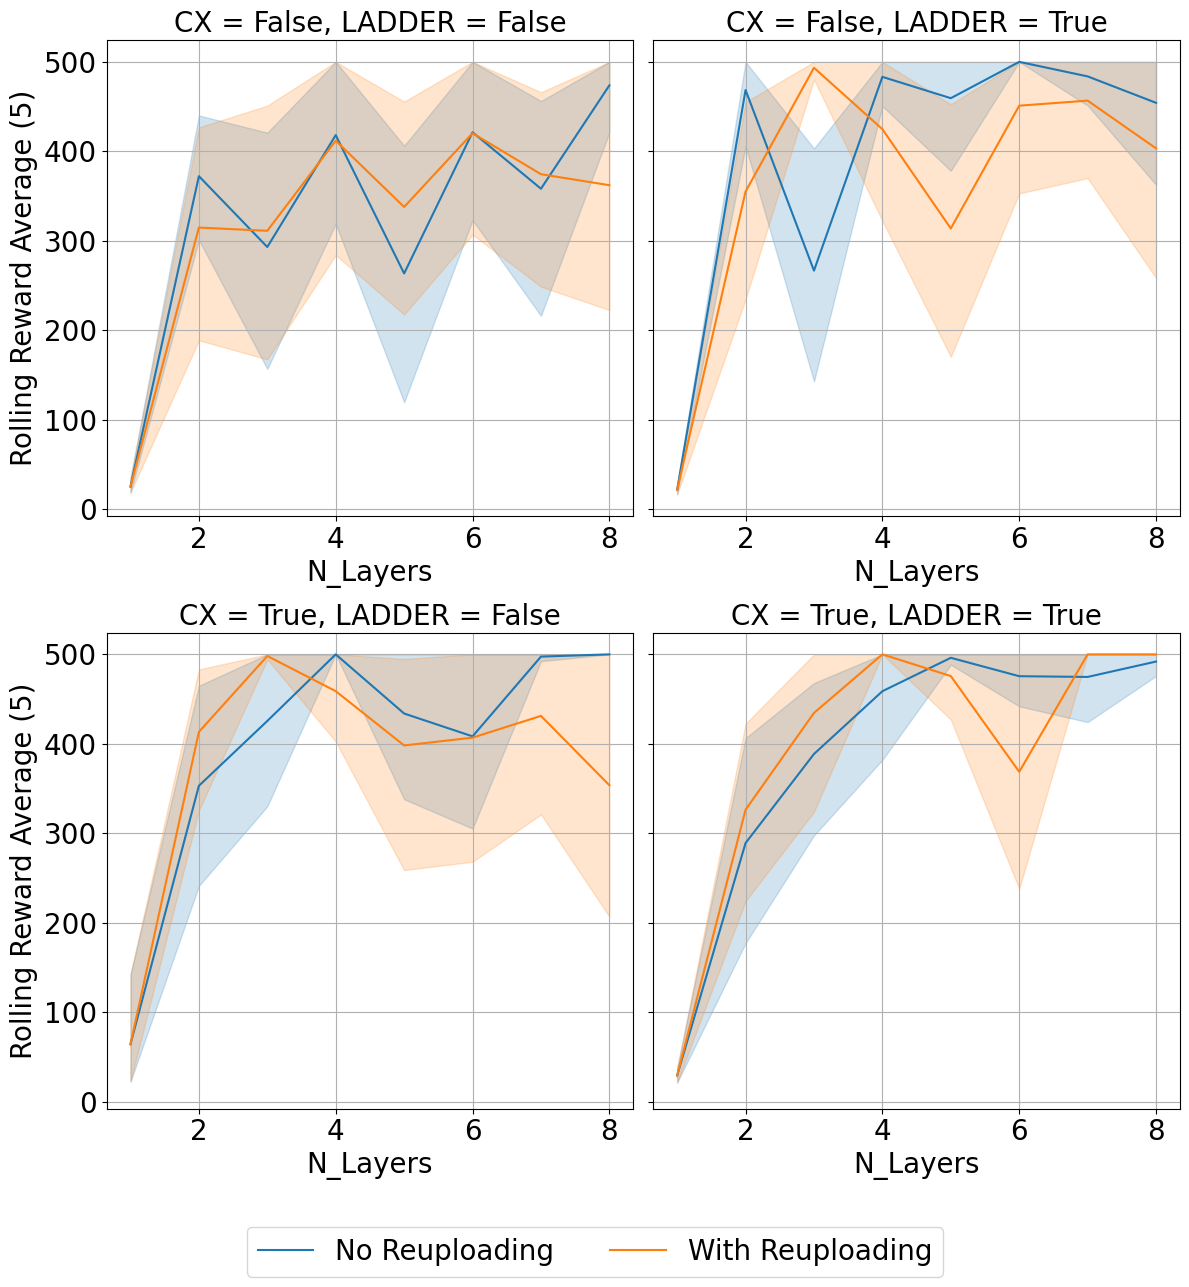

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

palette = {0: "C0", 1: "C1"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20

for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx, ladder]

        ax_.grid()

        sns.lineplot(
            x="n_layers",
            y="mean_5_reward",
            hue="reuploading",
            data=df[(df["cx"] == cx) & (df["ladder"] == ladder)],
            markers=True,
            dashes=True,
            markersize=8,
            ax=ax_,
            palette=palette,
            legend=True,
        )

        ax_.set_title(f"CX = {bool(cx)}, LADDER = {bool(ladder)}", fontsize=BIGGER_SIZE)
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("Rolling Reward Average (5)", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading"]
fig.legend(lines, labels, loc="lower center", ncol=2, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()


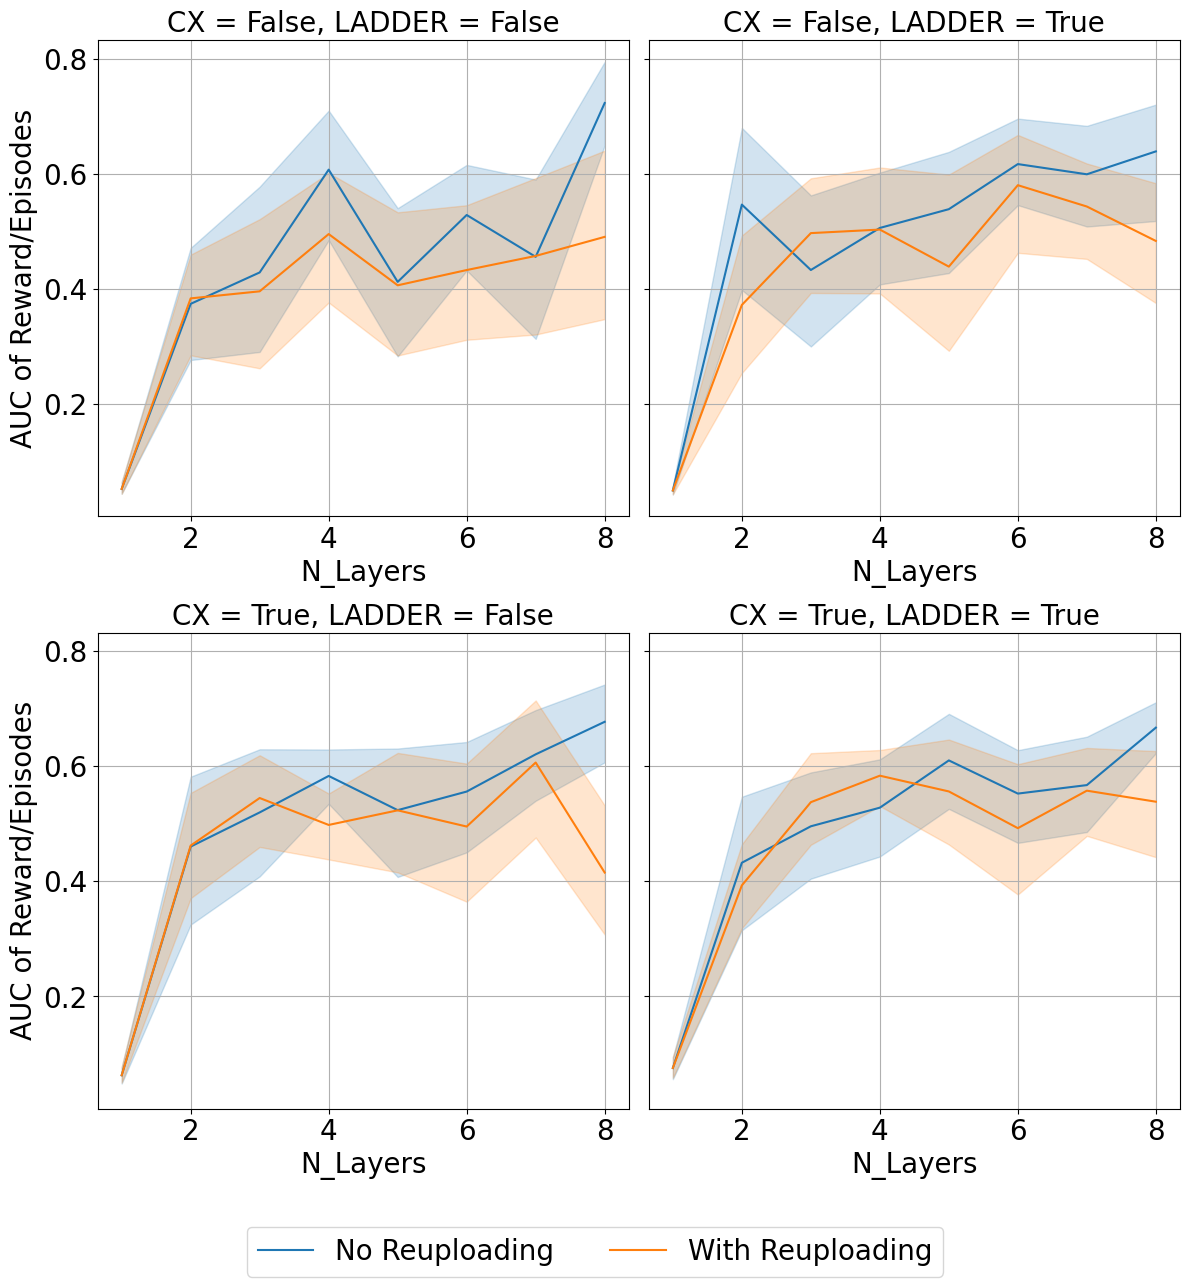

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

palette = {0: "C0", 1: "C1"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20

for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx, ladder]

        ax_.grid()

        sns.lineplot(
            x="n_layers",
            y="AUC",
            hue="reuploading",
            data=df[(df["cx"] == cx) & (df["ladder"] == ladder)],
            markers=True,
            dashes=True,
            markersize=8,
            ax=ax_,
            palette=palette,
            legend=True,
        )

        ax_.set_title(f"CX = {bool(cx)}, LADDER = {bool(ladder)}", fontsize=BIGGER_SIZE)
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("AUC of Reward/Episodes", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading"]
fig.legend(lines, labels, loc="lower center", ncol=2, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()


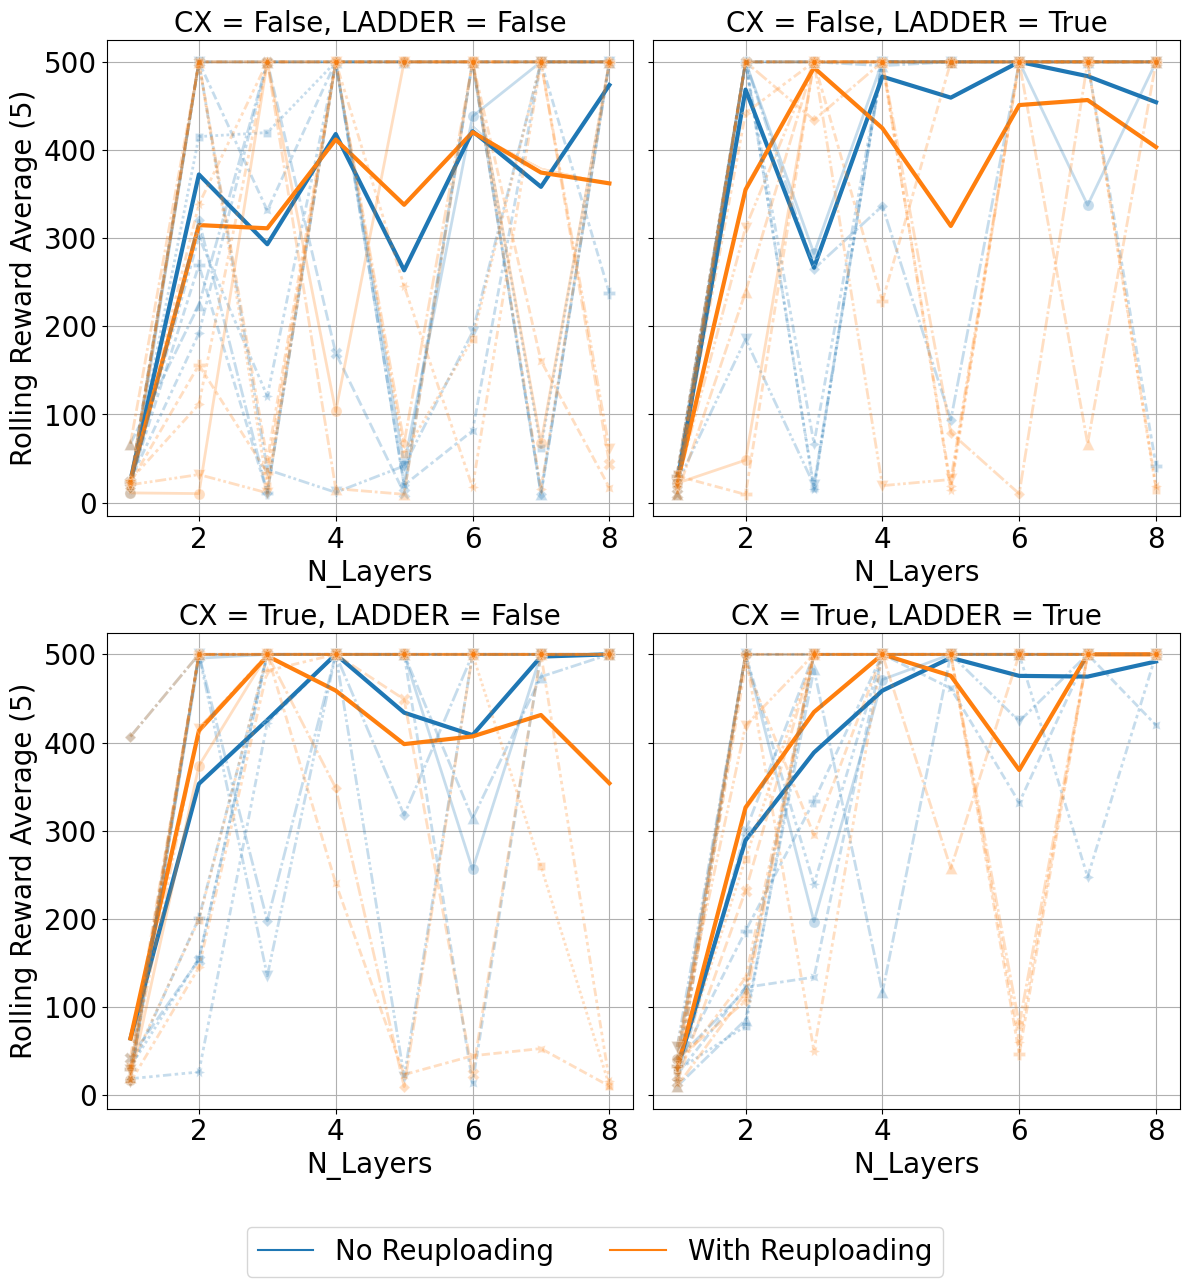

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

palette = {0: "C0", 1: "C1"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20

for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx, ladder]

        ax_.grid()

        sns.lineplot(
            x="n_layers",
            y="mean_5_reward",
            hue="reuploading",
            data=df[(df["cx"] == cx) & (df["ladder"] == ladder)],
            markers=True,
            dashes=True,
            markersize=8,
            ax=ax_,
            palette=palette,
            errorbar=('ci', 0),
            linewidth=3,
        )

        sns.lineplot(
            x="n_layers",
            y="mean_5_reward",
            hue="reuploading",
            style="seed",
            data=df[(df["cx"] == cx) & (df["ladder"] == ladder)],
            markers=True,
            dashes=True,
            markersize=8,
            ax=ax_,
            palette=palette,
            errorbar=('ci', 0),
            alpha=0.25,
            legend=False,
            linewidth=2,
        )

        ax_.set_title(f"CX = {bool(cx)}, LADDER = {bool(ladder)}", fontsize=BIGGER_SIZE)
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("Rolling Reward Average (5)", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading"]
fig.legend(lines, labels, loc="lower center", ncol=2, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()


In [16]:
df.columns

Index(['reuploading', 'cx', 'ladder', 'n_layers', 'seed', 'batch_size', 'lr',
       'n_episodes', 'max_steps', 'gamma', 'is_classical', 'epsilon_start',
       'epsilon_decay', 'epsilon_min', 'buffer_size', 'target_update_freq',
       'online_train_freq', 'win_thr', 'done', 'win', 'episode', 'last_reward',
       'mean_reward', 'std_reward', 'max_reward', 'min_reward',
       'mean_5_reward', 'AUC', 'benchmark_rewards', 'benchmark_wins'],
      dtype='object')

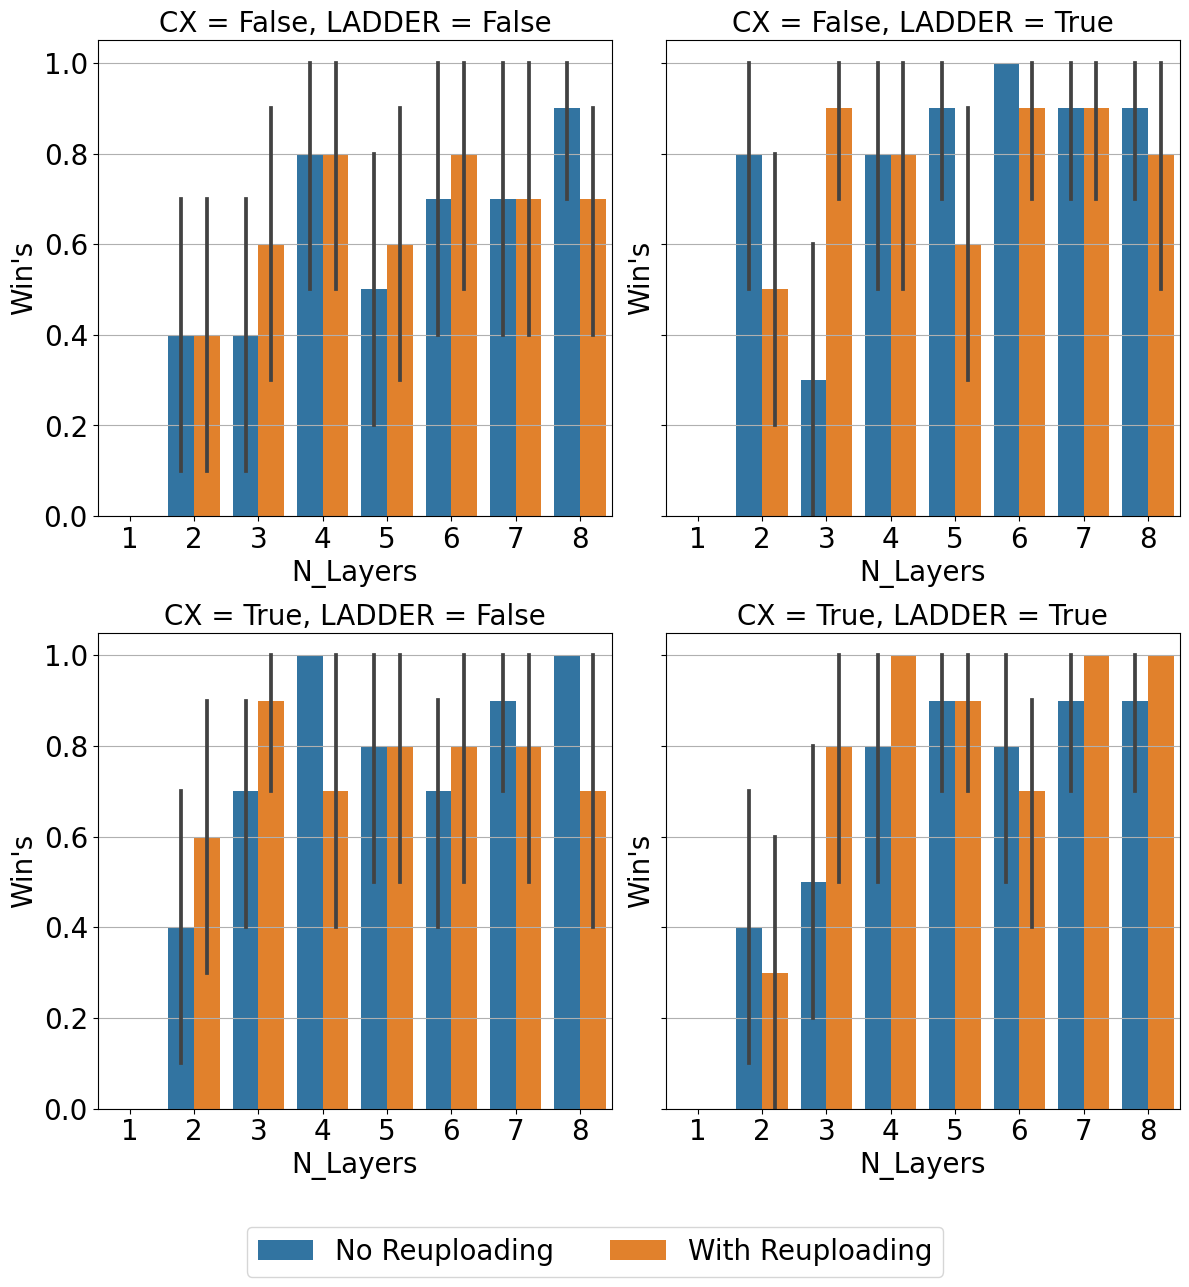

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

palette = {0: "C0", 1: "C1"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20

for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx, ladder]

        ax_.grid()

        # Plot barchart of done vs not done
        sns.barplot(
            x="n_layers",
            y="win",
            hue="reuploading",
            data=df[(df["cx"] == cx) & (df["ladder"] == ladder)],
            ax=ax_,
            palette=palette,
            #legend=True,
        )

        ax_.set_title(f"CX = {bool(cx)}, LADDER = {bool(ladder)}", fontsize=BIGGER_SIZE)
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("Win's", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading"]
fig.legend(lines, labels, loc="lower center", ncol=2, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()


### Best episode

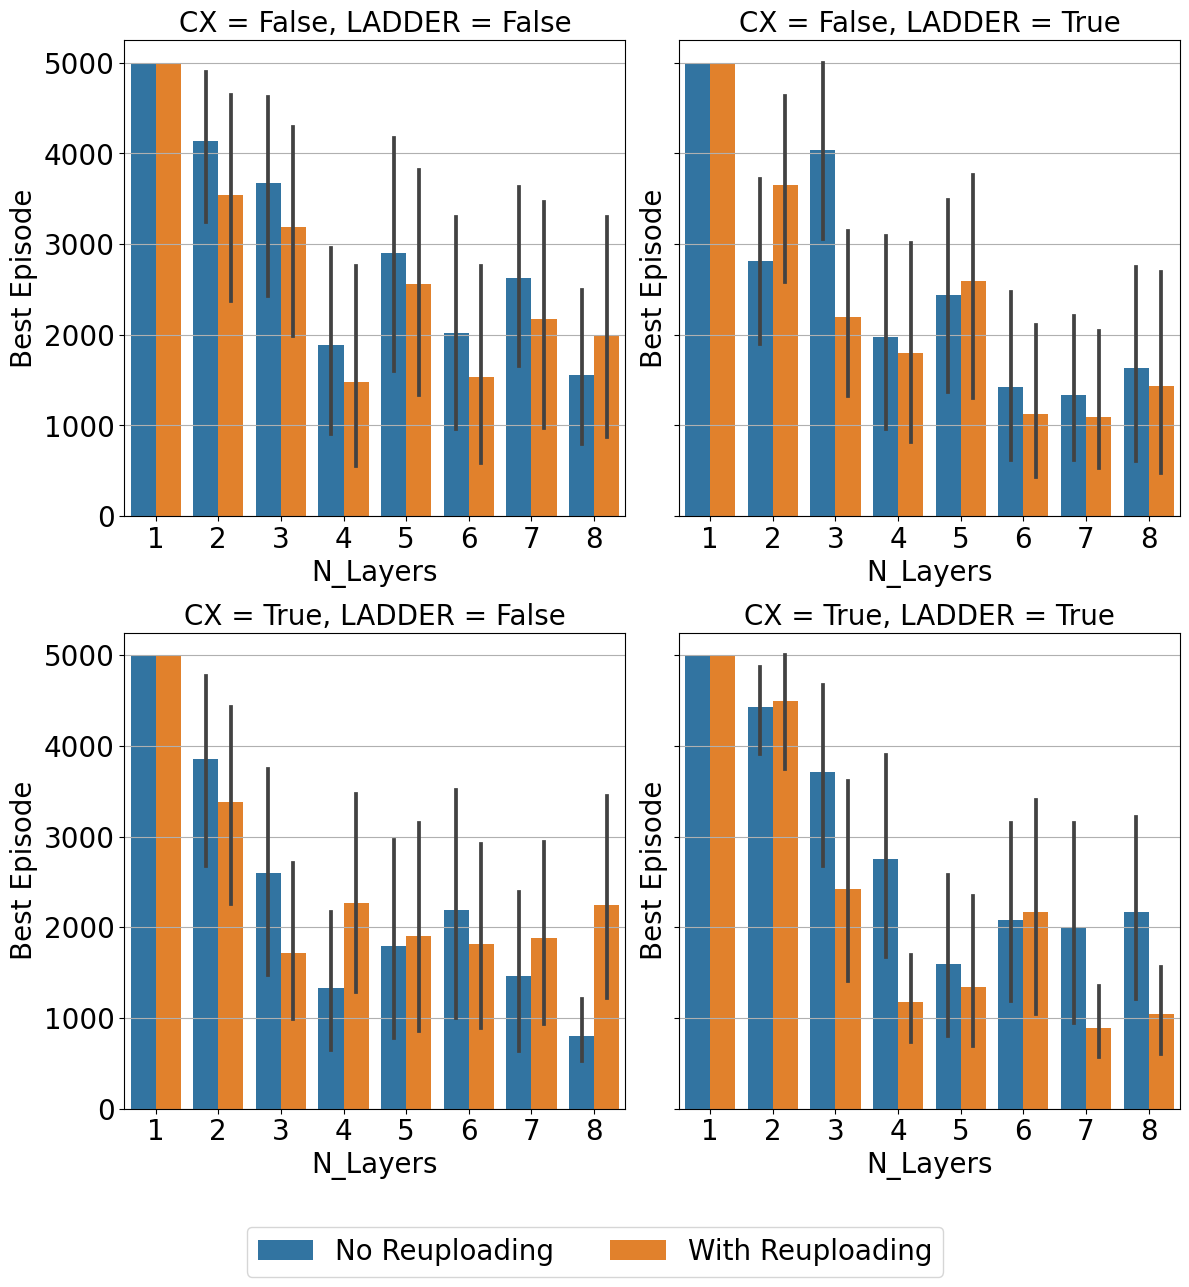

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

palette = {0: "C0", 1: "C1"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20

for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx, ladder]

        ax_.grid()

        # Plot barchart of done vs not done
        sns.barplot(
            x="n_layers",
            y="episode",
            hue="reuploading",
            data=df[(df["cx"] == cx) & (df["ladder"] == ladder)],
            ax=ax_,
            palette=palette,
            #legend=True,
        )

        ax_.set_title(f"CX = {bool(cx)}, LADDER = {bool(ladder)}", fontsize=BIGGER_SIZE)
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("Best Episode", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading"]
fig.legend(lines, labels, loc="lower center", ncol=2, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()


# Benchmark

In [19]:
df

,reuploading,cx,ladder,n_layers,seed,batch_size,lr,n_episodes,max_steps,gamma,...,episode,last_reward,mean_reward,std_reward,max_reward,min_reward,mean_5_reward,AUC,benchmark_rewards,benchmark_wins
0,0,0,1,8,4,16,0.001,5000,500,0.99,...,4999,24.0,93.643000,138.023236,500.0,8.0,42.0,0.187286,344.33,41
1,1,1,0,5,5,16,0.001,5000,500,0.99,...,4999,10.0,82.079800,96.219737,500.0,8.0,9.6,0.164160,149.30,2
2,0,1,1,6,10,16,0.001,5000,500,0.99,...,1045,500.0,257.412046,159.900098,500.0,9.0,500.0,0.514824,500.00,100
3,0,1,1,3,10,16,0.001,5000,500,0.99,...,4999,232.0,224.310800,101.643844,500.0,8.0,239.2,0.448622,409.31,1
4,0,0,1,2,1,16,0.001,5000,500,0.99,...,1754,500.0,390.704843,173.840217,500.0,8.0,500.0,0.781410,499.55,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0,1,1,7,1,16,0.001,5000,500,0.99,...,872,500.0,410.678121,156.986901,500.0,8.0,500.0,0.821356,500.00,100
636,0,0,1,5,2,16,0.001,5000,500,0.99,...,1495,500.0,336.846257,137.062782,500.0,8.0,500.0,0.673693,500.00,100
637,1,1,0,4,2,16,0.001,5000,500,0.99,...,4999,500.0,150.813000,128.136441,500.0,8.0,500.0,0.301626,499.37,98
638,1,1,1,4,3,16,0.001,5000,500,0.99,...,2367,500.0,303.024916,166.401249,500.0,8.0,500.0,0.606050,498.76,91


In [20]:
df['benchmark_rewards'].max()

500.0

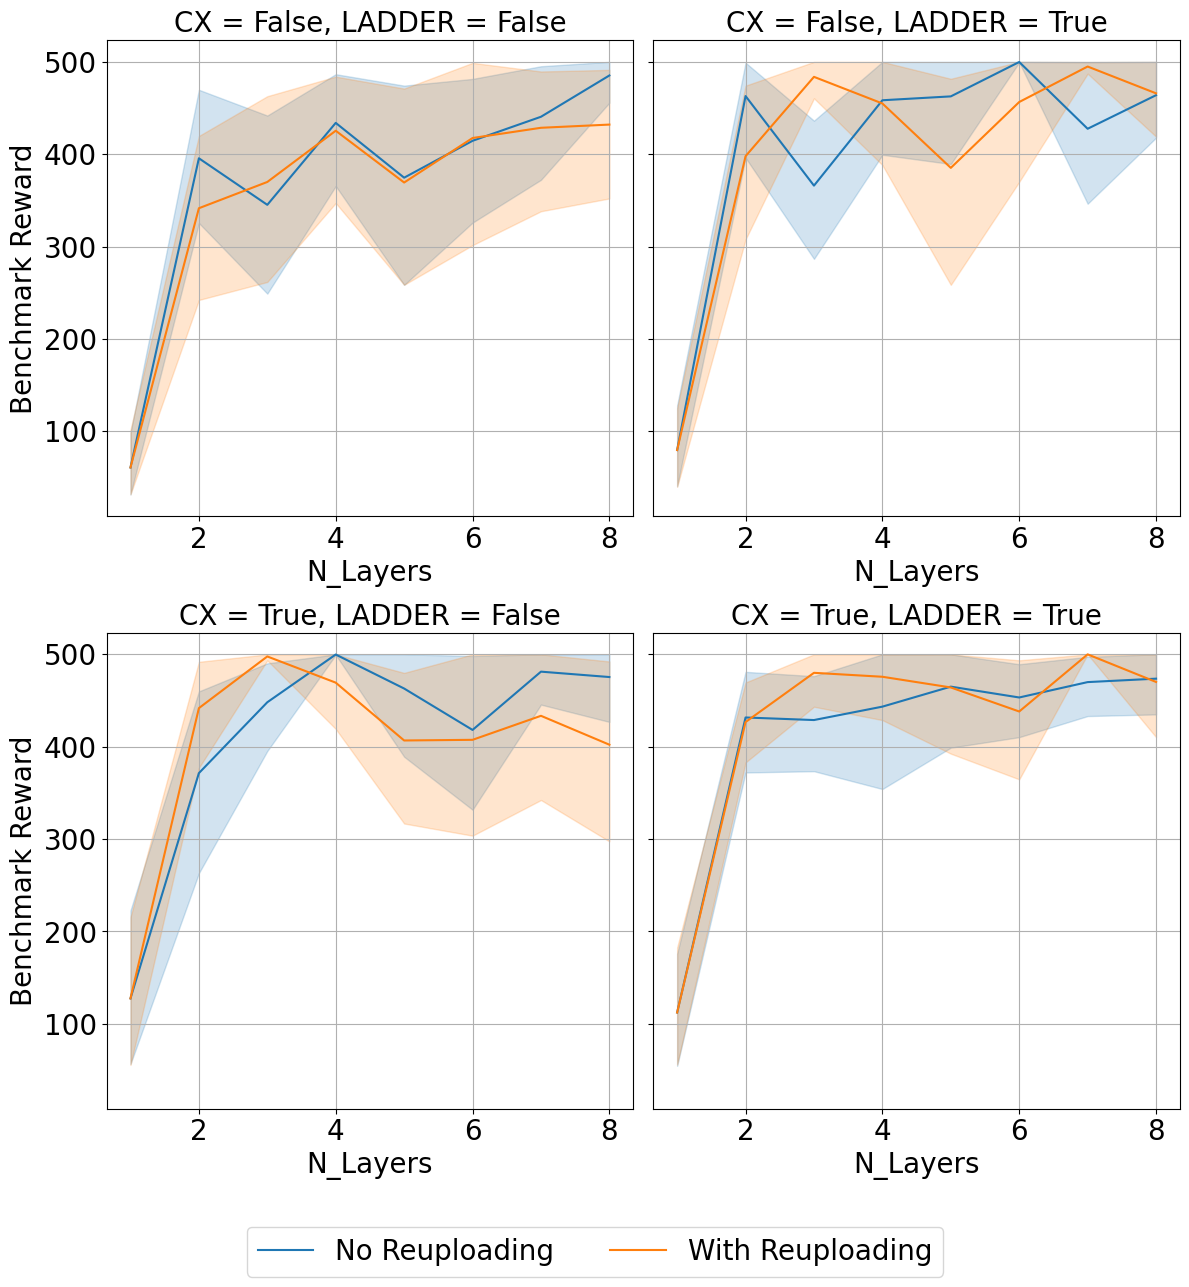

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

palette = {0: "C0", 1: "C1"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20

for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx, ladder]

        ax_.grid()

        sns.lineplot(
            x="n_layers",
            y="benchmark_rewards",
            hue="reuploading",
            data=df[(df["cx"] == cx) & (df["ladder"] == ladder)],
            markers=True,
            dashes=True,
            markersize=8,
            ax=ax_,
            palette=palette,
            legend=True,
        )

        ax_.set_title(f"CX = {bool(cx)}, LADDER = {bool(ladder)}", fontsize=BIGGER_SIZE)
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("Benchmark Reward", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading"]
fig.legend(lines, labels, loc="lower center", ncol=2, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()


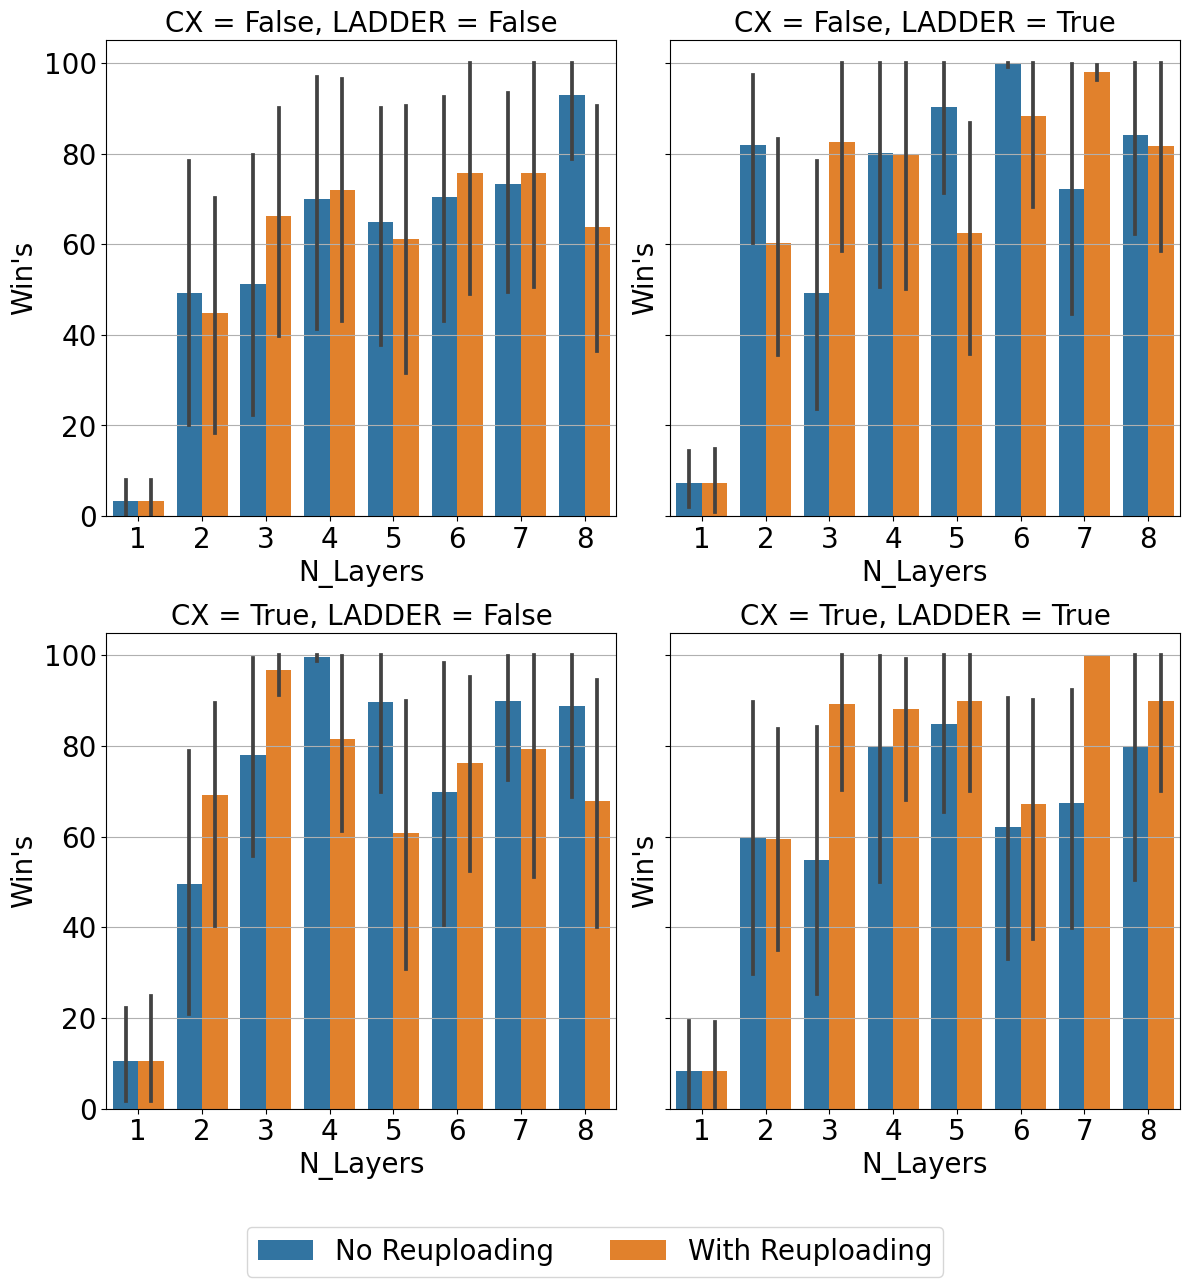

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

palette = {0: "C0", 1: "C1"}

LEGEND_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
TICK_SIZE = 20

for cx in range(2):
    for ladder in range(2):
        ax_ = ax[cx, ladder]

        ax_.grid()

        # Plot barchart of done vs not done
        sns.barplot(
            x="n_layers",
            y="benchmark_wins",
            hue="reuploading",
            data=df[(df["cx"] == cx) & (df["ladder"] == ladder)],
            ax=ax_,
            palette=palette,
            #legend=True,
        )

        ax_.set_title(f"CX = {bool(cx)}, LADDER = {bool(ladder)}", fontsize=BIGGER_SIZE)
        ax_.set_xlabel("N_Layers", fontsize=MEDIUM_SIZE)
        ax_.set_ylabel("Win's", fontsize=MEDIUM_SIZE)
        ax_.legend(fontsize=LEGEND_SIZE)
        ax_.tick_params(axis="both", which="major", labelsize=TICK_SIZE)
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


labels = ["No Reuploading", "With Reuploading"]
fig.legend(lines, labels, loc="lower center", ncol=2, fontsize=LEGEND_SIZE, bbox_to_anchor=(0.5, -0.08))

# Remove all legends
for ax in fig.axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

fig.tight_layout()
